_This notebook contains code and comments from Section 1.3 of the book [Ensemble Methods for Machine Learning](http://www.manning.com). Please see the book for additional details on this topic. This notebook and code are released under the [MIT license](https://github.com/gkunapuli/ensemble-methods-notebooks/blob/master/LICENSE)._

---

## 1.3 Fit vs. Complexity in Machine-Learning Models 

We will explore fit vs. complexity (a simpler view of the bias-variance dilemma) through a regression task on the classic benchmark **Boston Housing** data set.

First, load and view the data set using pandas

In [1]:
from sklearn.datasets import load_boston
boston = load_boston()

import pandas as pd
df = pd.DataFrame(data=boston['data'], columns=boston['feature_names'])
df['price'] = boston['target']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


Standardize the data to be zero-mean, unit standard deviation, and the labels to be in the range [-1, 1].

In [2]:
from sklearn.preprocessing import StandardScaler
X, y = load_boston(return_X_y=True)

X = StandardScaler().fit_transform(X)
y = StandardScaler().fit_transform(y.reshape(-1, 1))

---
### 1.3.1 Regression with Decision Trees

Perform 5 runs of the following:
- Split the data into training (67%) and test (33%) sets randomly
- Fit (train) decision trees of different depths in the range 1 to 10 on the training set 
- Evaluate each of the trees on both the training set (to get the training score) and test set (to get the test score) using [R2 coefficient](https://en.wikipedia.org/wiki/Coefficient_of_determination) as the scoring metric

In [3]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import validation_curve
import numpy as np

subsets = ShuffleSplit(n_splits=5, test_size=0.33, random_state=23)

model = DecisionTreeRegressor()
trn_scores, tst_scores = validation_curve(model, X, y, \
                param_name='max_depth', param_range=range(1, 11), \
                cv=subsets, scoring='r2')
mean_train_score = np.mean(trn_scores, axis=1) 
mean_test_score = np.mean(tst_scores, axis=1)  

Plot the training and test score curves.

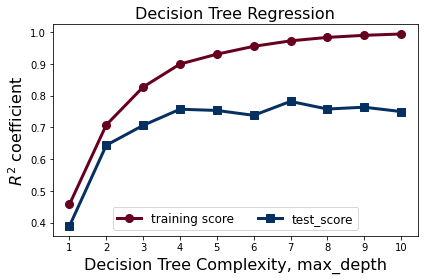

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
from visualization import get_colors
col = get_colors(colormap='RdBu')

fig = plt.figure()
plt.plot(range(1, 11), mean_train_score, linewidth=3, color=col[0], marker='o', markersize=8);
plt.plot(range(1, 11), mean_test_score, linewidth=3, color=col[1], marker='s', markersize=8);
plt.legend(['training score', 'test_score'], loc='lower center', ncol=2, fontsize=12)
plt.xlabel('Decision Tree Complexity, max_depth', fontsize=16);
plt.ylabel('$R^2$ coefficient', fontsize=16);
plt.xticks(range(1, 11));
plt.title('Decision Tree Regression', fontsize=16)
fig.tight_layout()

plt.savefig('./figures/CH01_F05_Kunapuli.png', format='png', dpi=300, bbox_inches='tight');

An R2 score close to 1 means that the model achieves nearly zero error and is very good. 

As decision trees become deeper (more complex) the training scores increase and the resulting models **fit** the data increasingly better. However, the test scores do not correspondingly increase and the resulting models do not **generalize** better. Thus, the most complex model with the best fit on the training set is not necessarily the best model for future predictions.

---
### 1.3.2 Regression with Support Vector Machines

SVMs aim to minimize an objective function of the form 

_objective function = complexity(model) + C*loss(model, data)._

As C increases, the loss term becomes more dominant, forcing the SVM to minimize the loss and improve the fit. As it does so however, for larger values of C, the complexity term is increasingly ignored and the model becomes more complex. 

This behavior is visualized below for a simple 1d regression problem where the (synthetic) data is generated from the true function $y = \frac{\sin x}{x}$.

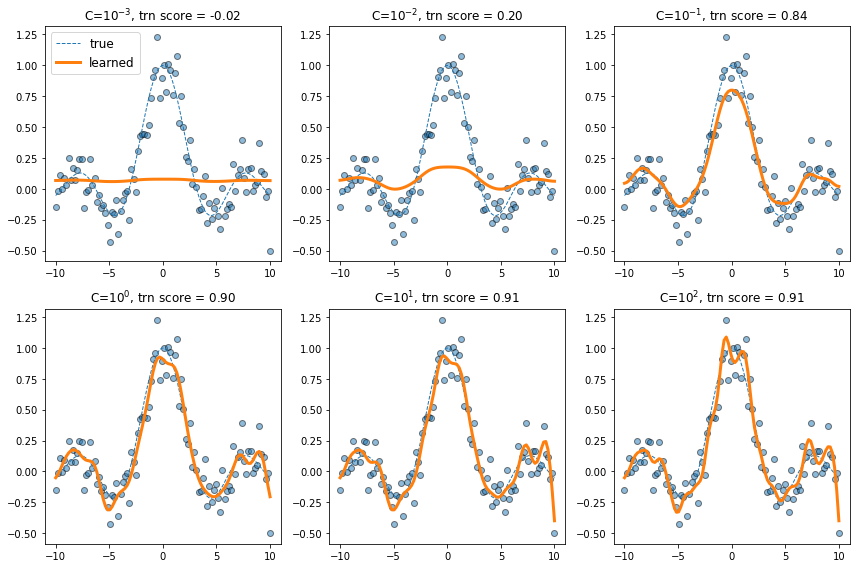

In [5]:
%matplotlib inline

from sklearn.svm import SVR
from sklearn.metrics import r2_score

n_syn = 100
X_syn = np.linspace(-10.0, 10.0, n_syn).reshape(-1, 1)
y_true = np.sin(X_syn) / X_syn
y_true = y_true.ravel()
y_syn = y_true + 0.125 * np.random.normal(0.0, 1.0, y_true.shape)
y_syn[-1] = -0.5  # Add one very noisy point to illustrate (exaggeratedly), the impact of overfitting

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
for k, C in enumerate(10.0**np.arange(-3, 3)):
    # Find the correct axis row and column and plot the noisy data and the true function
    i, j = np.divmod(k, 3)
    ax[i, j].scatter(X_syn[:, 0], y_syn, edgecolors='k', alpha=0.5);
    ax[i, j].plot(X_syn[:, 0], y_true, linewidth=1, linestyle='--', label='true');
    
    # Learn an SVM model for this value of C
    model = SVR(C=C, kernel='rbf', gamma=0.75)
    model.fit(X_syn, y_syn)
    y_pred = model.predict(X_syn)
    
    # Plot the learned SVM model for this value of C
    ax[i, j].plot(X_syn[:, 0], y_pred, linewidth=3, linestyle='-', label='learned');
    
    # Finish up the plots
    trn_score = r2_score(y_syn, y_pred)
    ax[i, j].set_title('C=$10^{{ {0} }}$, trn score = {1:3.2f}'.format(int(np.log10(C)), trn_score))
    
    # Put legend on one plot
    if k == 0:
        handles, labels = ax[i, j].get_legend_handles_labels()
        ax[i, j].legend(handles, labels, loc='upper left', fontsize=12);
    

fig.tight_layout()
plt.savefig('./figures/CH01_F06_Kunapuli.png', format='png', dpi=300, bbox_inches='tight');

As C increases, the model moves from underfit to "good" fit. However, as C keeps increasing, the fit ultimately plateaus, though the model continues to become more nonlinear and complex. This increasing complexity makes it start deviating from the true underlying function and leads to **overfitting**, which ultimately hurts generalization on future data points.

Now we return to the Boston Housing data set and repeat the same experiment as we did with decision trees.

Perform 5 runs of the following:
- Use the same subsets from the previous experiment with decision trees
- Fit (train) SVRs of different with different C values (10<sup>-2</sup>, 10<sup>-1</sup>, ..., 10<sup>3</sup>, 10<sup>4</sup>) on the training set 
- Evaluate each of the trees on both the training set (to get the training score) and test set (to get the test score) using [R2 coefficient](https://en.wikipedia.org/wiki/Coefficient_of_determination) as the scoring metric

In [6]:
from sklearn.svm import SVR

model = SVR(degree=3)
trn_scores, tst_scores = validation_curve(model, X, y.ravel(),    
                                          param_name='C',  
                                          param_range=np.logspace(-2,4,7), 
                                          cv=subsets, scoring='r2')

mean_train_score = np.mean(trn_scores, axis=1) 
mean_test_score = np.mean(tst_scores, axis=1)  

Plot the training and test score curves.

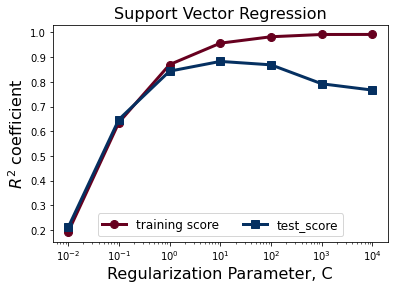

In [7]:
%matplotlib inline

plt.semilogx(np.logspace(-2, 4, 7), mean_train_score, linewidth=3, color=col[0], marker='o', markersize=8);
plt.semilogx(np.logspace(-2, 4, 7), mean_test_score, linewidth=3, color=col[1], marker='s', markersize=8);
plt.legend(['training score', 'test_score'], loc='lower center', ncol=2, fontsize=12);
plt.xlabel('Regularization Parameter, C', fontsize=16);
plt.ylabel('$R^2$ coefficient', fontsize=16);
plt.title('Support Vector Regression', fontsize=16)
fig.tight_layout()

plt.savefig('./figures/CH01_F07_Kunapuli.png', format='png', dpi=300, bbox_inches='tight');

As with decision trees, a more complex model doesn fit the training data better, but without the corresponding generalization performance as indicated by the test score.